In [1]:
import os
import torch
import pickle
import numpy as np
import json
import matplotlib.pyplot as plt
import random
from PIL import Image
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.display import clear_output
import torch.nn.functional as F


## First report validation metrics

In [6]:
SPLIT_PATH = '/home/mog29/cogen/data_and_checkpoints/continual_learning'

def get_accs(treatment_name, deployment_round, task):
    if treatment_name == 'human':
        json_path = os.path.join(SPLIT_PATH, 'analysis', 'human_human.json')
        with open(json_path, 'r') as f:
            data = json.load(f)
    else:
        suffix = task if treatment_name in ['no_ds', 'baseline'] else 'all'
        json_path = os.path.join(SPLIT_PATH, f'cl_r{deployment_round}_{treatment_name}_{suffix}.json')
        with open(json_path, 'r') as f:
            data = json.load(f)

    accs = []
    for game_id, game_dict in data.items():
        if treatment_name != 'human' and task not in game_id:
            continue
        if f'r{deployment_round}' not in game_id:
            continue
        for round_idx, round_dict in game_dict.items():
            accs.append(1 if round_dict['reward'] == 1 else 0)

    return np.array(accs)

def confidence_intervals(treatment_name, deployment_round, task, 
                         n_bootstrap, confidence_level):
    # 1: Get the per interaction accuracies
    accs = get_accs(treatment_name, deployment_round, task)
    n = len(accs)

    # 2: Perform bootstrapping
    bootstrapped_accs = np.empty(n_bootstrap)
    for i in range(n_bootstrap):
        sample_indices = np.random.randint(0, n, n)
        sample = accs[sample_indices]
        bootstrapped_accs[i] = np.mean(sample)
        
    # 3: Compute confidence interval
    lower_percentile = (1 - confidence_level) / 2 * 100
    upper_percentile = (1 + confidence_level) / 2 * 100
    confidence_interval = np.percentile(bootstrapped_accs, [lower_percentile, upper_percentile])

    acc = np.mean(accs)
    print(f"Treatment {treatment_name} round {deployment_round}: {acc*100:.2f} {[round(val*100, 2) for val in confidence_interval]}")

    return np.mean(accs), confidence_interval

In [7]:
treatments = ['full', 'no_ds', 'no_ji', 'baseline', 'human']
treatment_to_data = {treatment : [] for treatment in treatments}

# Getting the values
task = 'speaker'
n_bootstrap = 10000
confidence_level = 0.95
print(f'Printing results for {task}')
for treatment in treatments:
    for deployment_round in range(1, 5):
        returns = confidence_intervals(treatment, deployment_round, task, 
                                       n_bootstrap, confidence_level)
        treatment_to_data[treatment].append(returns)
    print()    

Printing results for speaker
Treatment full round 1: 52.00 [49.7, 54.2]
Treatment full round 2: 67.87 [66.07, 69.71]
Treatment full round 3: 75.00 [73.47, 76.53]
Treatment full round 4: 78.07 [76.67, 79.44]

Treatment no_ds round 1: 52.00 [49.8, 54.2]
Treatment no_ds round 2: 62.91 [61.02, 64.79]
Treatment no_ds round 3: 69.47 [67.8, 71.1]
Treatment no_ds round 4: 69.97 [68.46, 71.49]

Treatment no_ji round 1: 48.45 [46.25, 50.65]
Treatment no_ji round 2: 60.22 [58.34, 62.14]
Treatment no_ji round 3: 66.17 [64.43, 67.87]
Treatment no_ji round 4: 70.91 [69.42, 72.42]

Treatment baseline round 1: 48.45 [46.3, 50.7]
Treatment baseline round 2: 56.24 [54.28, 58.24]
Treatment baseline round 3: 59.83 [58.1, 61.6]
Treatment baseline round 4: 60.97 [59.34, 62.57]

Treatment human round 1: 86.45 [84.86, 87.94]
Treatment human round 2: 86.47 [85.11, 87.78]
Treatment human round 3: 86.00 [84.76, 87.23]
Treatment human round 4: 85.52 [84.33, 86.68]



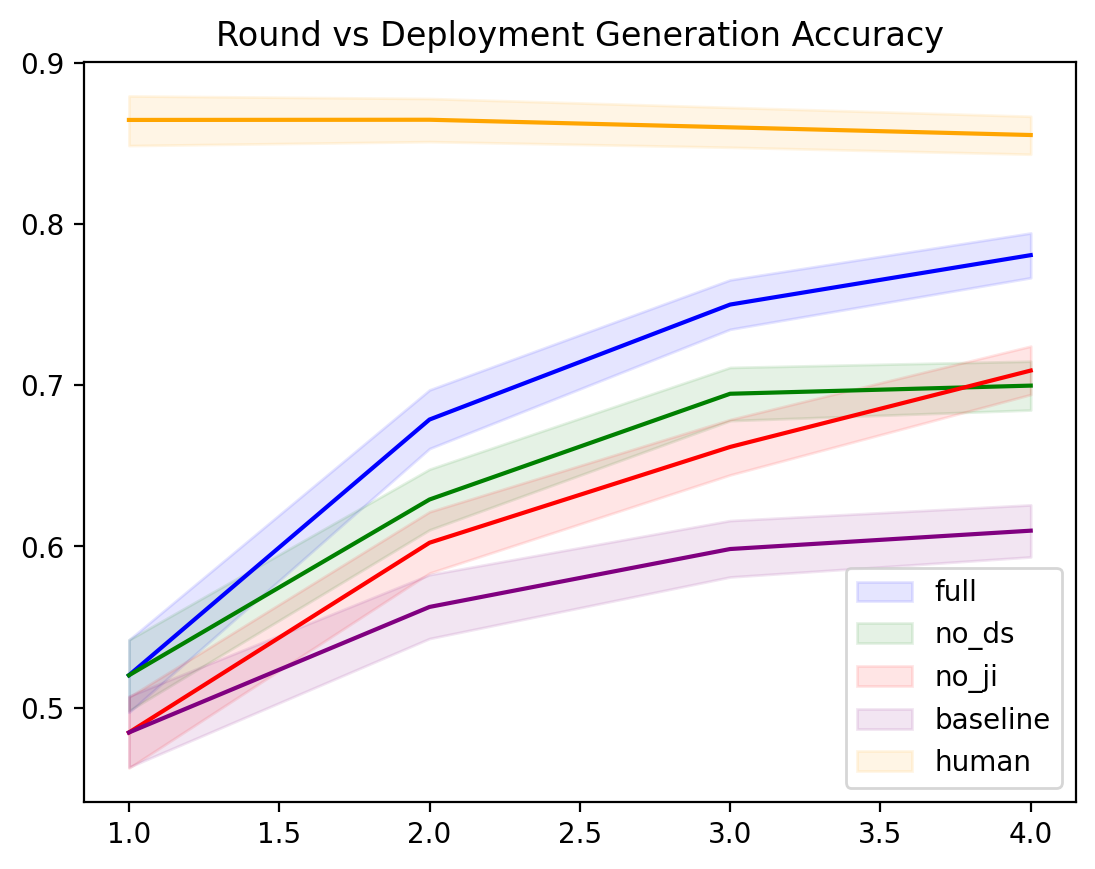

In [8]:
# Plot them
colors = ['blue', 'green', 'red', 'purple', 'orange']

for i, (treatment, treatment_data) in enumerate(treatment_to_data.items()):
    accs = [val[0] for val in treatment_data]
    lowers = [val[1][0] for val in treatment_data]
    uppers = [val[1][1] for val in treatment_data]
    
    plt.plot(np.arange(len(accs))+1, accs, color=colors[i])
    plt.fill_between(np.arange(len(accs))+1, lowers, uppers, alpha=0.1, color=colors[i], label=treatment)
    
plt.title('Round vs Deployment Generation Accuracy')

plt.legend()
plt.show()

In [9]:
for i, (treatment, treatment_data) in enumerate(treatment_to_data.items()):
    accs = [round(val[0] * 100, 2) for val in treatment_data]
    lowers = [round(val[1][0] * 100, 2) for val in treatment_data]
    uppers = [round(val[1][1] * 100, 2) for val in treatment_data]
    
    print(treatment)
    print('UpperCI: ', uppers)
    print('LowerCI: ', lowers)
    print('Acc: ', accs)
    print()

full
UpperCI:  [54.2, 69.71, 76.53, 79.44]
LowerCI:  [49.7, 66.07, 73.47, 76.67]
Acc:  [52.0, 67.87, 75.0, 78.07]

no_ds
UpperCI:  [54.2, 64.79, 71.1, 71.49]
LowerCI:  [49.8, 61.02, 67.8, 68.46]
Acc:  [52.0, 62.91, 69.47, 69.97]

no_ji
UpperCI:  [50.65, 62.14, 67.87, 72.42]
LowerCI:  [46.25, 58.34, 64.43, 69.42]
Acc:  [48.45, 60.22, 66.17, 70.91]

baseline
UpperCI:  [50.7, 58.24, 61.6, 62.57]
LowerCI:  [46.3, 54.28, 58.1, 59.34]
Acc:  [48.45, 56.24, 59.83, 60.97]

human
UpperCI:  [87.94, 87.78, 87.23, 86.68]
LowerCI:  [84.86, 85.11, 84.76, 84.33]
Acc:  [86.45, 86.47, 86.0, 85.52]



In [10]:
treatments = ['full', 'no_ds', 'no_ji', 'baseline', 'human']
treatment_to_data = {treatment : [] for treatment in treatments}

# Getting the values
task = 'listener'
n_bootstrap = 10000
confidence_level = 0.95
print(f'Printing results for {task}')
for treatment in treatments:
    for deployment_round in range(1, 5):
        returns = confidence_intervals(treatment, deployment_round, task, 
                                       n_bootstrap, confidence_level)
        treatment_to_data[treatment].append(returns)
    print()  

Printing results for listener
Treatment full round 1: 53.31 [51.15, 55.47]
Treatment full round 2: 65.24 [63.36, 67.08]
Treatment full round 3: 68.64 [67.0, 70.27]
Treatment full round 4: 72.79 [71.31, 74.28]

Treatment no_ds round 1: 53.31 [51.1, 55.52]
Treatment no_ds round 2: 59.70 [57.77, 61.62]
Treatment no_ds round 3: 62.47 [60.71, 64.21]
Treatment no_ds round 4: 64.73 [63.12, 66.33]

Treatment no_ji round 1: 42.64 [40.49, 44.84]
Treatment no_ji round 2: 54.24 [52.28, 56.2]
Treatment no_ji round 3: 61.64 [59.91, 63.38]
Treatment no_ji round 4: 66.86 [65.28, 68.4]

Treatment baseline round 1: 42.64 [40.49, 44.79]
Treatment baseline round 2: 51.34 [49.42, 53.3]
Treatment baseline round 3: 56.53 [54.69, 58.33]
Treatment baseline round 4: 57.99 [56.33, 59.62]

Treatment human round 1: 86.45 [84.92, 87.99]
Treatment human round 2: 86.47 [85.11, 87.78]
Treatment human round 3: 86.00 [84.73, 87.23]
Treatment human round 4: 85.52 [84.33, 86.68]



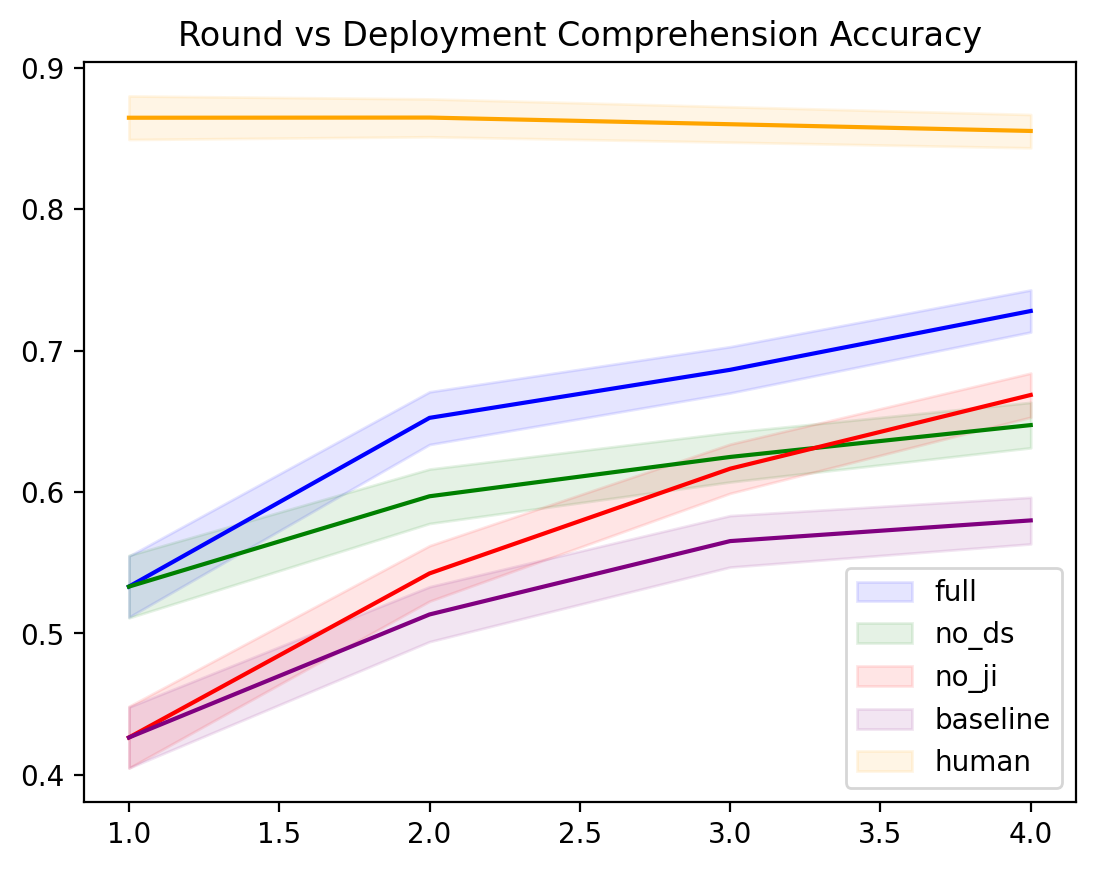

In [11]:
# Plot them
colors = ['blue', 'green', 'red', 'purple', 'orange']

for i, (treatment, treatment_data) in enumerate(treatment_to_data.items()):
    accs = [val[0] for val in treatment_data]
    lowers = [val[1][0] for val in treatment_data]
    uppers = [val[1][1] for val in treatment_data]
    
    plt.plot(np.arange(len(accs))+1, accs, color=colors[i])
    plt.fill_between(np.arange(len(accs))+1, lowers, uppers, alpha=0.1, color=colors[i], label=treatment)
    
plt.title('Round vs Deployment Comprehension Accuracy')

plt.legend()
plt.show()

In [12]:
for i, (treatment, treatment_data) in enumerate(treatment_to_data.items()):
    accs = [round(val[0] * 100, 2) for val in treatment_data]
    lowers = [round(val[1][0] * 100, 2) for val in treatment_data]
    uppers = [round(val[1][1] * 100, 2) for val in treatment_data]
    
    print(treatment)
    print('UpperCI: ', uppers)
    print('LowerCI: ', lowers)
    print('Acc: ', accs)
    print()

full
UpperCI:  [55.47, 67.08, 70.27, 74.28]
LowerCI:  [51.15, 63.36, 67.0, 71.31]
Acc:  [53.31, 65.24, 68.64, 72.79]

no_ds
UpperCI:  [55.52, 61.62, 64.21, 66.33]
LowerCI:  [51.1, 57.77, 60.71, 63.12]
Acc:  [53.31, 59.7, 62.47, 64.73]

no_ji
UpperCI:  [44.84, 56.2, 63.38, 68.4]
LowerCI:  [40.49, 52.28, 59.91, 65.28]
Acc:  [42.64, 54.24, 61.64, 66.86]

baseline
UpperCI:  [44.79, 53.3, 58.33, 59.62]
LowerCI:  [40.49, 49.42, 54.69, 56.33]
Acc:  [42.64, 51.34, 56.53, 57.99]

human
UpperCI:  [87.99, 87.78, 87.23, 86.68]
LowerCI:  [84.92, 85.11, 84.73, 84.33]
Acc:  [86.45, 86.47, 86.0, 85.52]



## Confidence Intervals for Initial System

In [13]:
def confidence_intervals(acc, num_samples, n_bootstrap, confidence_level):
    # 1: Get the per interaction accuracies
    num_pos = int(num_samples * acc)
    num_neg = num_samples - num_pos
    accs = np.array([1] * num_pos + [0] * num_neg)
    n = len(accs)

    # 2: Perform bootstrapping
    bootstrapped_accs = np.empty(n_bootstrap)
    for i in range(n_bootstrap):
        sample_indices = np.random.randint(0, n, n)
        sample = accs[sample_indices]
        bootstrapped_accs[i] = np.mean(sample)
        
    # 3: Compute confidence interval
    lower_percentile = (1 - confidence_level) / 2 * 100
    upper_percentile = (1 + confidence_level) / 2 * 100
    confidence_interval = np.percentile(bootstrapped_accs, [lower_percentile, upper_percentile])

    acc = np.mean(accs)
    return np.mean(accs), confidence_interval

In [16]:
# Comprehension:
n_bootstrap = 10000
confidence_level = 0.95
acc = 0.5373
acc, confidence_interval = confidence_intervals(acc, 3500, n_bootstrap, confidence_level)

print(round(acc * 100, 2), [round((acc - val) * 100, 2) for val in confidence_interval])

53.71 [1.66, -1.66]


In [17]:
# Generation:
n_bootstrap = 10000
confidence_level = 0.95
acc = 0.5456
acc, confidence_interval = confidence_intervals(acc, 3500, n_bootstrap, confidence_level)

print(round(acc * 100, 2), [round((acc - val) * 100, 2) for val in confidence_interval])

54.54 [1.66, -1.69]
